In [8]:
import pandas as pd
import datetime
import numpy as np

from langdetect import detect
from tqdm import tqdm_notebook

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

from itertools import chain 

from gensim.models import Phrases
from gensim import corpora
from gensim import models

In [9]:
import nltk
nltk.download('stopwords')

# Using the stopwords.
from nltk.corpus import stopwords

# Initialize the stopwords
stoplist = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/deepshikha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
data = pd.read_csv('articles_bbc_2018_01_30.csv')

In [11]:
data = data.dropna().reset_index(drop=True)

In [12]:
data.head()

,articles,lang
0,Image copyright PA/EPA Image caption Oligarch ...,en
1,Husband admits killing French jogger\r\n\r\nTh...,en
2,Media playback is unsupported on your device M...,en
3,Manchester City's Leroy Sane is ruled out for ...,en
4,Image copyright AFP Image caption Sebastien Br...,en


In [13]:
tqdm_notebook().pandas()

In [14]:
data['lang'] = data.articles.progress_map(detect)

In [8]:
data.lang.value_counts()

en    257
fa      9
fr      7
id      5
uk      4
ru      4
ar      4
vi      4
hi      4
sw      3
es      2
tr      2
pt      2
de      1
Name: lang, dtype: int64

In [9]:
data = data.loc[data.lang=='en']

In [11]:
data['sentences'] = data.articles.progress_map(sent_tokenize)
data['sentences'].head(1).tolist()[0][:3] # Print the first 3 sentences of the 1st article

['Image copyright PA/EPA Image caption Oligarch Roman Abramovich (l) and PM Dmitry Medvedev are on the list\r\n\r\nRussian President Vladimir Putin says a list of officials and businessmen close to the Kremlin published by the US has in effect targeted all Russian people.',
 'The list names 210 top Russians as part of a sanctions law aimed at punishing Moscow for meddling in the US election.',
 'However, the US stressed those named were not subject to new sanctions.']

In [13]:
data['tokens_sentences'] = data['sentences'].progress_map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
print(data['tokens_sentences'].head(1).tolist()[0][:3])


[['Image', 'copyright', 'PA/EPA', 'Image', 'caption', 'Oligarch', 'Roman', 'Abramovich', '(', 'l', ')', 'and', 'PM', 'Dmitry', 'Medvedev', 'are', 'on', 'the', 'list', 'Russian', 'President', 'Vladimir', 'Putin', 'says', 'a', 'list', 'of', 'officials', 'and', 'businessmen', 'close', 'to', 'the', 'Kremlin', 'published', 'by', 'the', 'US', 'has', 'in', 'effect', 'targeted', 'all', 'Russian', 'people', '.'], ['The', 'list', 'names', '210', 'top', 'Russians', 'as', 'part', 'of', 'a', 'sanctions', 'law', 'aimed', 'at', 'punishing', 'Moscow', 'for', 'meddling', 'in', 'the', 'US', 'election', '.'], ['However', ',', 'the', 'US', 'stressed', 'those', 'named', 'were', 'not', 'subject', 'to', 'new', 'sanctions', '.']]


In [15]:
data['POS_tokens'] = data['tokens_sentences'].progress_map(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])
print(data['POS_tokens'].head(1).tolist()[0][:3])


[[('Image', 'NN'), ('copyright', 'NN'), ('PA/EPA', 'NNP'), ('Image', 'NNP'), ('caption', 'NN'), ('Oligarch', 'NNP'), ('Roman', 'NNP'), ('Abramovich', 'NNP'), ('(', '('), ('l', 'NN'), (')', ')'), ('and', 'CC'), ('PM', 'NNP'), ('Dmitry', 'NNP'), ('Medvedev', 'NNP'), ('are', 'VBP'), ('on', 'IN'), ('the', 'DT'), ('list', 'NN'), ('Russian', 'NNP'), ('President', 'NNP'), ('Vladimir', 'NNP'), ('Putin', 'NNP'), ('says', 'VBZ'), ('a', 'DT'), ('list', 'NN'), ('of', 'IN'), ('officials', 'NNS'), ('and', 'CC'), ('businessmen', 'NNS'), ('close', 'RB'), ('to', 'TO'), ('the', 'DT'), ('Kremlin', 'NNP'), ('published', 'VBN'), ('by', 'IN'), ('the', 'DT'), ('US', 'NNP'), ('has', 'VBZ'), ('in', 'IN'), ('effect', 'NN'), ('targeted', 'VBN'), ('all', 'DT'), ('Russian', 'JJ'), ('people', 'NNS'), ('.', '.')], [('The', 'DT'), ('list', 'NN'), ('names', 'RB'), ('210', 'CD'), ('top', 'JJ'), ('Russians', 'NNPS'), ('as', 'IN'), ('part', 'NN'), ('of', 'IN'), ('a', 'DT'), ('sanctions', 'NNS'), ('law', 'NN'), ('aimed',

In [17]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [18]:
# Lemmatizing each word with its POS tag, in each sentence
data['tokens_sentences_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

In [19]:
data['tokens_sentences_lemmatized'].head(1).tolist()[0][:3]

[['Image',
  'copyright',
  'PA/EPA',
  'Image',
  'caption',
  'Oligarch',
  'Roman',
  'Abramovich',
  '(',
  'l',
  ')',
  'and',
  'PM',
  'Dmitry',
  'Medvedev',
  'be',
  'on',
  'the',
  'list',
  'Russian',
  'President',
  'Vladimir',
  'Putin',
  'say',
  'a',
  'list',
  'of',
  'official',
  'and',
  'businessmen',
  'close',
  'to',
  'the',
  'Kremlin',
  'publish',
  'by',
  'the',
  'US',
  'have',
  'in',
  'effect',
  'target',
  'all',
  'Russian',
  'people',
  '.'],
 ['The',
  'list',
  'names',
  '210',
  'top',
  'Russians',
  'as',
  'part',
  'of',
  'a',
  'sanction',
  'law',
  'aim',
  'at',
  'punish',
  'Moscow',
  'for',
  'meddle',
  'in',
  'the',
  'US',
  'election',
  '.'],
 ['However',
  ',',
  'the',
  'US',
  'stress',
  'those',
  'name',
  'be',
  'not',
  'subject',
  'to',
  'new',
  'sanction',
  '.']]

In [21]:
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
my_stopwords = stoplist + stopwords_verbs + stopwords_other

In [23]:
data['tokens'] = data['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data['tokens'] = data['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

In [24]:
data['tokens'].head(1).tolist()[0][:30]

['oligarch',
 'roman',
 'abramovich',
 'pm',
 'dmitry',
 'medvedev',
 'list',
 'russian',
 'president',
 'vladimir',
 'putin',
 'list',
 'official',
 'businessmen',
 'close',
 'kremlin',
 'publish',
 'us',
 'effect',
 'target',
 'russian',
 'people',
 'list',
 'names',
 'top',
 'russians',
 'part',
 'sanction',
 'law',
 'aim']

In [26]:
tokens = data['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

In [28]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

In [30]:
np.random.seed(123456)
num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 1.65 s, sys: 3.43 ms, total: 1.66 s
Wall time: 1.67 s


In [31]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.012*"specie" + 0.010*"prey" + 0.007*"act" + 0.006*"animal" + 0.006*"help" + 0.005*"back" + 0.005*"find" + 0.005*"become" + 0.005*"behaviour" + 0.005*"number" + 0.005*"area" + 0.005*"include" + 0.004*"order" + 0.004*"kill" + 0.004*"approach" + 0.004*"however" + 0.004*"move" + 0.004*"host" + 0.004*"evolve" + 0.004*"well"

1: 0.010*"show" + 0.008*"game" + 0.007*"another" + 0.007*"light" + 0.007*"night" + 0.006*"find" + 0.006*"could" + 0.006*"predator" + 0.006*"animal" + 0.006*"give" + 0.006*"images" + 0.006*"question" + 0.006*"however" + 0.006*"group" + 0.006*"live" + 0.006*"time" + 0.005*"transparent" + 0.005*"drug" + 0.005*"eye" + 0.005*"call"

2: 0.006*"first" + 0.006*"people" + 0.006*"work" + 0.005*"city" + 0.005*"time" + 0.005*"year" + 0.004*"day" + 0.004*"part" + 0.004*"find" + 0.004*"could" + 0.004*"us" + 0.003*"run" + 0.003*"restaurant" + 0.003*"plan" + 0.003*"home" + 0.003*"start" + 0.003*"tunnel" + 0.003*"include" + 0.003*"bring" + 0.003*"dish"

3: 0.014*"separatist" + 0.01

In [32]:
print(data.articles.loc[0][:500])

Image copyright PA/EPA Image caption Oligarch Roman Abramovich (l) and PM Dmitry Medvedev are on the list

Russian President Vladimir Putin says a list of officials and businessmen close to the Kremlin published by the US has in effect targeted all Russian people.

The list names 210 top Russians as part of a sanctions law aimed at punishing Moscow for meddling in the US election.

However, the US stressed those named were not subject to new sanctions.

Mr Putin said the list was an unfr


In [33]:
lda_model[corpus[0]]

[(15, 0.99830645)]

In [34]:
document = '''Eric Tucker, a 35-year-old co-founder of a marketing company in Austin, Tex., had just about 40 Twitter followers. But his recent tweet about paid protesters being bused to demonstrations against President-elect Donald J. Trump fueled a nationwide conspiracy theory — one that Mr. Trump joined in promoting. 

Mr. Tucker's post was shared at least 16,000 times on Twitter and more than 350,000 times on Facebook. The problem is that Mr. Tucker got it wrong. There were no such buses packed with paid protesters.

But that didn't matter.

While some fake news is produced purposefully by teenagers in the Balkans or entrepreneurs in the United States seeking to make money from advertising, false information can also arise from misinformed social media posts by regular people that are seized on and spread through a hyperpartisan blogosphere.

Here, The New York Times deconstructs how Mr. Tucker’s now-deleted declaration on Twitter the night after the election turned into a fake-news phenomenon. It is an example of how, in an ever-connected world where speed often takes precedence over truth, an observation by a private citizen can quickly become a talking point, even as it is being proved false.'''
tokens = word_tokenize(document)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,2,0.40,"0.006*""first"" + 0.006*""people"" + 0.006*""work"" ..."
1,8,0.22,"0.012*""us"" + 0.008*""russia"" + 0.007*""could"" + ..."
2,10,0.29,"0.009*""people"" + 0.006*""government"" + 0.006*""u..."
3,17,0.09,"0.010*""idea"" + 0.008*""work"" + 0.008*""link"" + 0..."


In [35]:
topics = [lda_model[corpus[i]] for i in range(len(data))]

In [36]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,NaN,NaN,NaN,NaN,NaN,0.0913012,NaN,NaN,0.869287,NaN


In [37]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [38]:
# Which document are about topic 14
document_topic.sort_values(14, ascending=False)[14].head(20)

248    0.999237
58     0.999117
256    0.997293
15     0.996790
41     0.993013
244    0.992777
218    0.991440
116    0.973609
170    0.963455
163    0.954756
225    0.913619
66     0.816265
161    0.617414
237    0.366396
16     0.294009
34     0.284695
236    0.283284
167    0.143202
252    0.110725
8      0.088885
Name: 14, dtype: float64

In [39]:
print(data.articles.loc[91][:1000])

Image caption Brendan Cole was a professional dancer on Strictly Come Dancing for 13 years

Brendan Cole has announced he will not be returning to Strictly Come Dancing.

The professional dancer revealed during a TV interview on Tuesday that the decision was made by the BBC, saying he was "in shock".

"They made an editorial decision not to have me back on the show," he said on ITV's Lorraine.

A spokesman for the BBC One show thanked Cole for "being part of the show since the beginning" and contributing to its success.

'Emotional and raw'

Cole said: "I'm a little bit in shock at the moment.

"I'm quite emotional and a bit raw about it. I am very disappointed. It's an editorial decision. I will never know the ins and outs.

"I have had 15 incredible series on the show, I'm very proud of the whole show, they're a great team."

Media playback is unsupported on your device Media caption In an interview on 16 January, Brendan Cole told 5 live he wanted to return to Stri


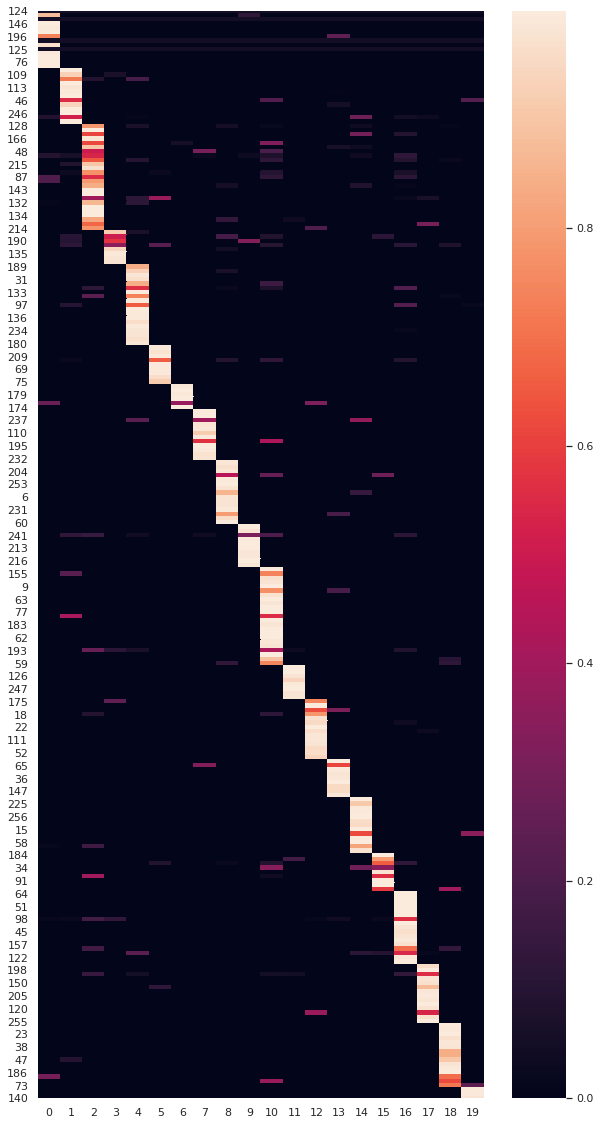

In [40]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

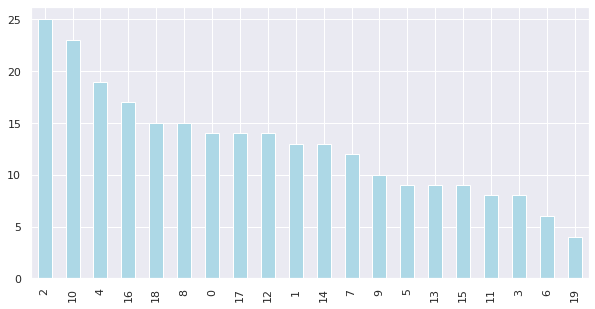

In [41]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

In [ ]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)